In [63]:
# Dependencies
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR

In [72]:
# Load data (FRED-MD)
df = pd.read_csv('current.csv')

# Remove the first row (transformation codes)
transformation_codes = df.iloc[0]  # Transformation codes can be applied if needed
df = df.iloc[1:]

# Set the first column as the index and datetime
df.set_index(df.columns[0], inplace=True)
df.index = pd.to_datetime(df.index)
original_data = df.copy()

# Transform and standardize the data
df_logged = np.sign(df) * np.log1p(np.abs(df))

# Split into train and test sets
FORECAST_HORIZON = 12
train = df_logged[:-FORECAST_HORIZON]
test = df[-FORECAST_HORIZON:]["CPIAUCSL"]

# Standardize based on training data only to avoid data leakage
df_logged_train = (train - train.mean()) / train.std()

In [73]:
# Apply PCA on the training data
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(df_logged_train.dropna())
train_pca = pd.DataFrame(pca_data, index=df_logged_train.dropna().index)

# Add CPIAUCSL (dependent variable) to PCA transformed data
train_pca["CPIAUCSL"] = original_data["CPIAUCSL"].dropna()


In [74]:
# Create the VAR Model using the transformed training data
var_model = VAR(train_pca)

# Select optimal lag using BIC (can also use AIC)
best_lag = var_model.select_order().bic
print(f"Optimal Lag: {best_lag}")

# Fit the model with the best lag order
var_results = var_model.fit(best_lag)

# Generate forecast using the most recent values
forecast = var_results.forecast(train_pca.values[-best_lag:], steps=FORECAST_HORIZON)

/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal Lag: 1


In [76]:
# Create DataFrame for the forecast
inflation = pd.DataFrame(forecast, columns=train_pca.columns, index=test.index)["CPIAUCSL"]

# Transform CPIAUCSL back to original scale
# inflation = np.sign(inflation) * (np.exp(np.abs(inflation)) - 1)
inflation


sasdate
2024-01-01    309.452998
2024-02-01    310.169626
2024-03-01    310.891281
2024-04-01    311.617601
2024-05-01    312.348438
2024-06-01    313.083839
2024-07-01    313.824008
2024-08-01    314.569286
2024-09-01    315.320110
2024-10-01    316.076991
2024-11-01    316.840478
2024-12-01    317.611137
Name: CPIAUCSL, dtype: float64

In [77]:
# Calculate RMSE
with open("var_results.txt", "a") as f:
    f.write(f"Lags: {best_lag}, Horizon: {FORECAST_HORIZON}\n")
    f.write(f"RMSE: {np.sqrt(np.mean((inflation - test)**2))}\n")
    f.write(f"R^2: {1 - np.sum((inflation - test)**2) / np.sum((test - test.mean())**2)}\n\n")

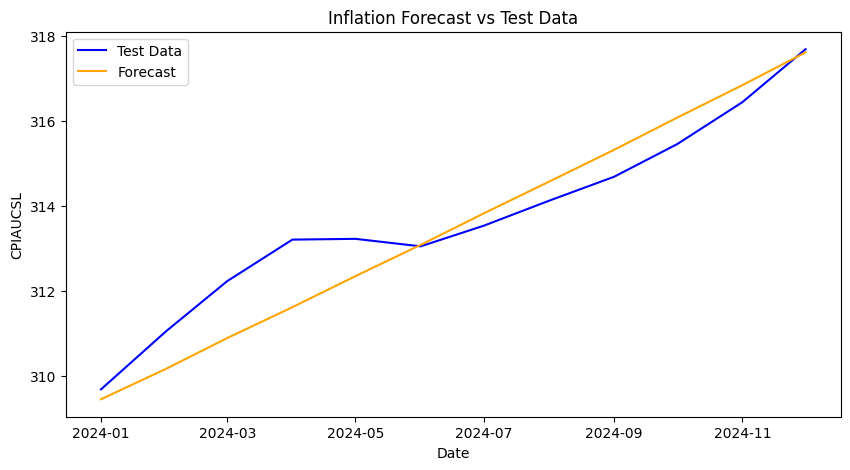

In [78]:
# Plot inflation vs test
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Test Data', color='blue')
plt.plot(inflation.index, inflation, label='Forecast', color='orange')
plt.title('Inflation Forecast vs Test Data')
plt.xlabel('Date')
plt.ylabel('CPIAUCSL')
plt.legend()
plt.show()

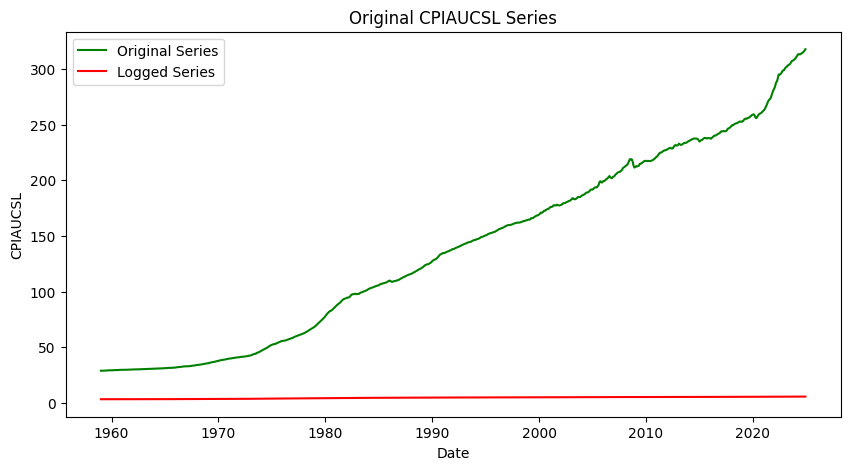

In [71]:
# Plot the original series
plt.figure(figsize=(10, 5))

original_series = pd.read_csv('current.csv', index_col=0)
original_series = original_series.iloc[1:]
original_series.index = pd.to_datetime(original_series.index)
plt.plot(original_series.index, original_series["CPIAUCSL"], label='Original Series', color='green')

# Plot the log
logged_data = np.sign(original_series) * np.log1p(np.abs(original_series))
plt.plot(logged_data.index, logged_data["CPIAUCSL"], label='Logged Series', color='red')

plt.title('Original CPIAUCSL Series')
plt.xlabel('Date')
plt.ylabel('CPIAUCSL')
plt.legend()
plt.show()